In [1]:
# Install all important libraries
!pip install yfinance
!pip install ta

zsh:1: command not found: pip
zsh:1: command not found: pip


In [2]:
# SGX list Dont run
list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [5]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


**MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast

Rules --> Variables --> Parameters

Rule --> Short Term Moving average Crosses a Long term Moving average
Variables --> Short MA / Long MA
Parameters --> 5 and 21


In [24]:
# Making a class for the strategy
# init method to construct and provide all the variables that will be required by the strategy

class Backtester():

  def __init__(self, symbol, start, end, STMA_window, LTMA_window, interval):
    self.performance_data = pd.DataFrame(data=[symbol], columns=["STOCK"])
    self.symbol = symbol
    self.STMA_window = STMA_window
    self.LTMA_window= LTMA_window
    self.start = start
    self.end = end
    self.interval = interval
    self.prepare_data()


  def prepare_data(self):

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    indicator_1 = SMAIndicator(close = hist_stock["Close"], window = self.STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = hist_stock["Close"], window = self.LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["STMA"] = STMA
    bt_data["LTMA"] = LTMA
    bt_data = bt_data.dropna()
    self.data = bt_data

  def strategy(self):
    bt_data = self.data.copy()
    bt_data["Position"] = np.where(bt_data['STMA'] > bt_data['LTMA'], 1.0, -1.0)
    bt_data["Signal"] = bt_data['Position'].diff()
    bt_data = bt_data.dropna()

    bt_data['Stock_Returns'] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data["Strategy_Returns"] = bt_data["Stock_Returns"] * bt_data["Position"].shift(1)

    self.visualise_data = bt_data

  def visualise_strategy(self):
    plt.figure(figsize=(15, 5))
    plt.plot(self.visualise_data["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.plot(self.visualise_data["STMA"], color='b', label='Short term MA')
    plt.plot(self.visualise_data["LTMA"], color='r', label='Long term MA')
    plt.plot(self.visualise_data[self.visualise_data['Signal'] == 2].index,
            self.visualise_data['STMA'][self.visualise_data['Signal'] == 2],
            '^', markersize = 15, color = 'g', label = 'buy/long')
    plt.plot(self.visualise_data[self.visualise_data['Signal'] == -2].index,
            self.visualise_data['STMA'][self.visualise_data['Signal'] == -2],
            'v', markersize = 15, color = 'r', label = 'sell/short')

    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Moving Averages Crossover {} Vs {}".format(self.STMA_window, self.LTMA_window))
    plt.legend()
    plt.grid()
    plt.show()

  def performance(self):
    self.performance_data["STOCK_RETURNS"], self.performance_data["STRAT_RETURNS"] = self.calc_returns()
    self.performance_data["STOCK_SD"], self.performance_data["STRAT_SD"] = self.calc_sd()
    self.performance_data["STOCK_SR"], self.performance_data["STRAT_SR"] = self.calc_sharpe()
    self.performance_data["MAX_DRAWDOWN"] = self.calc_drawdowns()
    self.performance_data["CALMAR_RATIO"] = self.calc_calmar_ratio()
    self.performance_data["SORTINO_RATIO"] = self.calc_sortino_ratio()
    print(self.performance_data)

  def calc_returns(self):
    strat_annual_regular_returns = (self.visualise_data["Strategy_Returns"].map(lambda x: np.exp(x) - 1)).mean() * 252
    stock_annual_regular_returns = (self.visualise_data["Stock_Returns"].map(lambda x: np.exp(x) - 1)).mean() * 252
    return stock_annual_regular_returns, strat_annual_regular_returns
    
  def calc_sd(self):
    strat_annual_regular_std = (self.visualise_data["Strategy_Returns"].map(lambda x: np.exp(x) - 1)).std() * (252 ** 0.5)
    stock_annual_regular_std = (self.visualise_data["Stock_Returns"].map(lambda x: np.exp(x) - 1)).std() * (252 ** 0.5)
    return stock_annual_regular_std, strat_annual_regular_std
  
  def calc_drawdowns(self):
    self.visualise_data['Gross_Cum_Returns'] = self.visualise_data["Strategy_Returns"].cumsum().apply(np.exp)
    self.visualise_data['Cum_Max'] = self.visualise_data["Gross_Cum_Returns"].cummax()
    self.visualise_data['Drawdown'] = self.visualise_data['Cum_Max'] - self.visualise_data["Gross_Cum_Returns"]
    max_drawdown = self.visualise_data['Drawdown'].max()
    return max_drawdown

  def calc_calmar_ratio(self):
    calmar = self.performance_data['STRAT_RETURNS'] / abs(self.calc_drawdowns())
    return calmar

  def calc_sharpe(self):
    stock_sharpe_ratios, strat_sharpe_ratios = [], []
    stock_annual_regular_ret = (self.visualise_data["Stock_Returns"].map(lambda x: np.exp(x) - 1)).mean() * 252
    stock_annual_regular_std = (self.visualise_data["Stock_Returns"].map(lambda x: np.exp(x) - 1)).std() * (252 ** 0.5)
    strat_annual_regular_ret = (self.visualise_data["Strategy_Returns"].map(lambda x: np.exp(x) - 1)).mean() * 252
    strat_annual_regular_std = (self.visualise_data["Strategy_Returns"].map(lambda x: np.exp(x) - 1)).std() * (252 ** 0.5)
    stock_sr = stock_annual_regular_ret / stock_annual_regular_std
    strat_sr = strat_annual_regular_ret / strat_annual_regular_std
    stock_sharpe_ratios.append(stock_sr)
    strat_sharpe_ratios.append(strat_sr)
    return stock_sharpe_ratios, strat_sharpe_ratios

  def calc_sortino_ratio(self):
    non_positive_returns =  self.visualise_data.copy()
    non_positive_returns[non_positive_returns["Strategy_Returns"] > 0] = 0
    non_positive_returns = non_positive_returns["Strategy_Returns"]
    neg_std_dev = (np.exp(non_positive_returns)-1).std() * (252**0.5)
    sortino = self.performance_data["STRAT_RETURNS"] / neg_std_dev
    return sortino    

  def returns_plot(self):
    plt.figure(figsize=(10, 5))
    plt.plot(self.visualise_data["Stock_Returns"].cumsum(), label='Stock returns')
    plt.plot(self.visualise_data["Strategy_Returns"].cumsum(), label='Strategy returns')
    plt.title(f"Strategy vs Stock Returns for Stock: {self.symbol}")
    plt.legend()

  def drawdown_plot(self):
    self.visualise_data[["Gross_Cum_Returns", "Cum_Max"]].dropna().plot(figsize =(15,6))


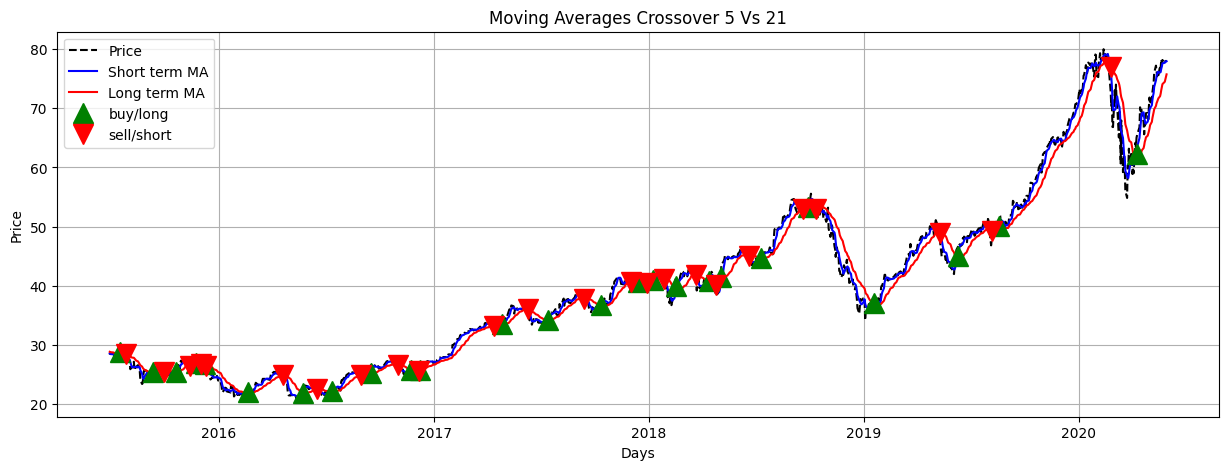

  STOCK  STOCK_RETURNS  STRAT_RETURNS  STOCK_SD  STRAT_SD  STOCK_SR  STRAT_SR  \
0  AAPL       0.248128       0.353208   0.28933  0.291104  0.857594  1.213337   

   MAX_DRAWDOWN  CALMAR_RATIO  SORTINO_RATIO  
0      0.713847      0.494795       2.135673  


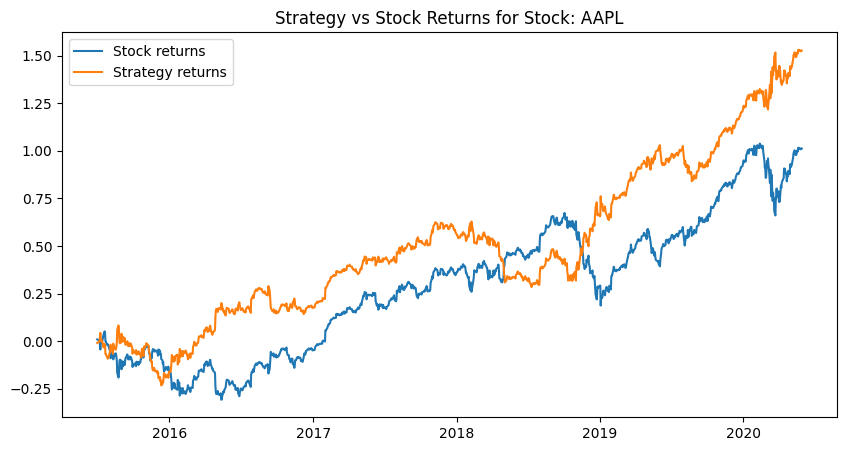

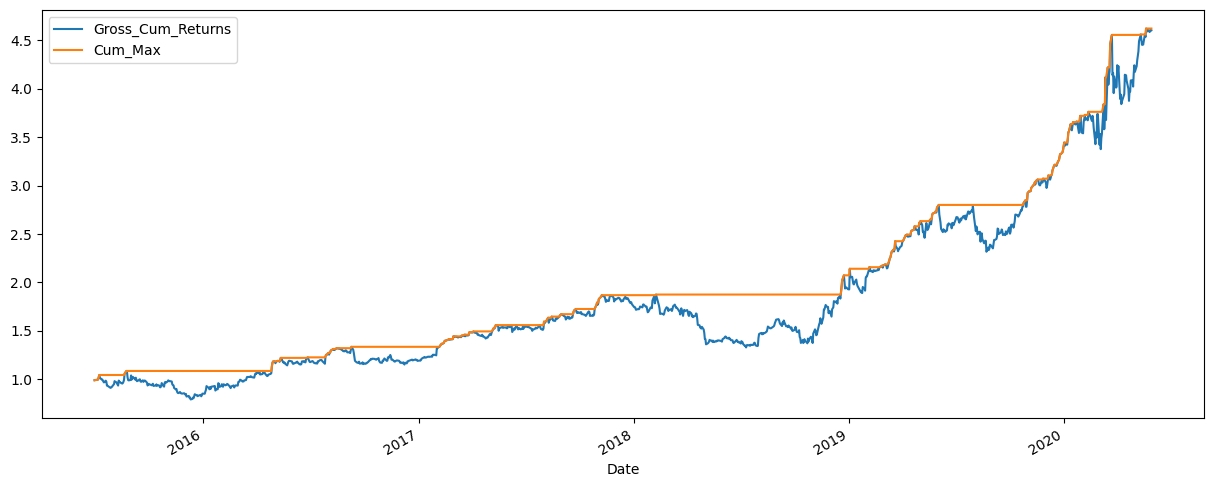

In [28]:
# main syntax is for running a single python file (.py) as a script. It is utillised by the python interpreter
# if testing in colab  or notebooks, can directly call the backtester

if __name__ == '__main__':

  # instantiate an instance of the main class Backtester
  start_date = "2015-06-01"
  end_date = "2020-06-01"
  output = Backtester("AAPL", start_date, end_date, 5, 21, "1d")

  #run the strategy
  output.strategy()

  #visulaise the crossover
  output.visualise_strategy()

  #get the performance
  output.performance()

  #plot the returns
  output.returns_plot()

  #plot the drawdown
  output.drawdown_plot()

In [ ]:
# You can run for your desired / logical parameters and stpre the results.
# You can also optimise with different libraries but I will not suggest optimizing.